In [1]:
import sys
sys.path.append('../code')
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline
plt.rcParams['figure.figsize']=(20,20)
plt.rcParams['font.size']= 30

In [2]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 28#24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [3]:
# val = [0.5+0.05*(10-i+1) for i in range(10)]
# val

val = []
dval = []
for i in np.linspace(0.1, 0.8, 100):
    val.append(i+(1/20)*np.sin(40*i))
    dval.append(1+2*np.cos(40*i))
    
val_ = []    
for i in range(len(val)):
    if i % 15 == 0:
        val_.append(val[i])
val_.append(val[-1])
val_ = np.array(val_)*1.5

In [4]:
# par1 = []
# par1.append(0.35)
# for i in range(199):
#     par1.append(par1[i]-0.0013)

par1 = []
dpar1 = []
for i in np.linspace(0.1, 0.99, 100):
    par1.append(2*(0.6-0.2*np.exp(i)))
    dpar1.append(2*(-0.2*np.exp(i)))
    
par1_ = []    
for i in range(len(par1)):
    if i % 15 == 0:
        par1_.append(par1[i])
par1_.append(par1[-1])

In [5]:
# par2 = []
# par2.append(0.5)
# for i in range(199):
#     par2.append(par2[i]+0.0021)

par2 = []
dpar2 = []
for i in np.linspace(0.1, 0.99, 100):
    par2.append(1.5*(1.2-0.7*np.exp(-i)-0.3))
    dpar2.append(1.5*(0.7*np.exp(-i)))
    
par2_ = []    
for i in range(len(par2)):
    if i % 15 == 0:
        par2_.append(par2[i])
par2_.append(par2[-1])
    

In [6]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [7]:
import seaborn as sns
sns.set('paper', 'white', font_scale=3.5)
plt.rcParams['font.family']='serif'

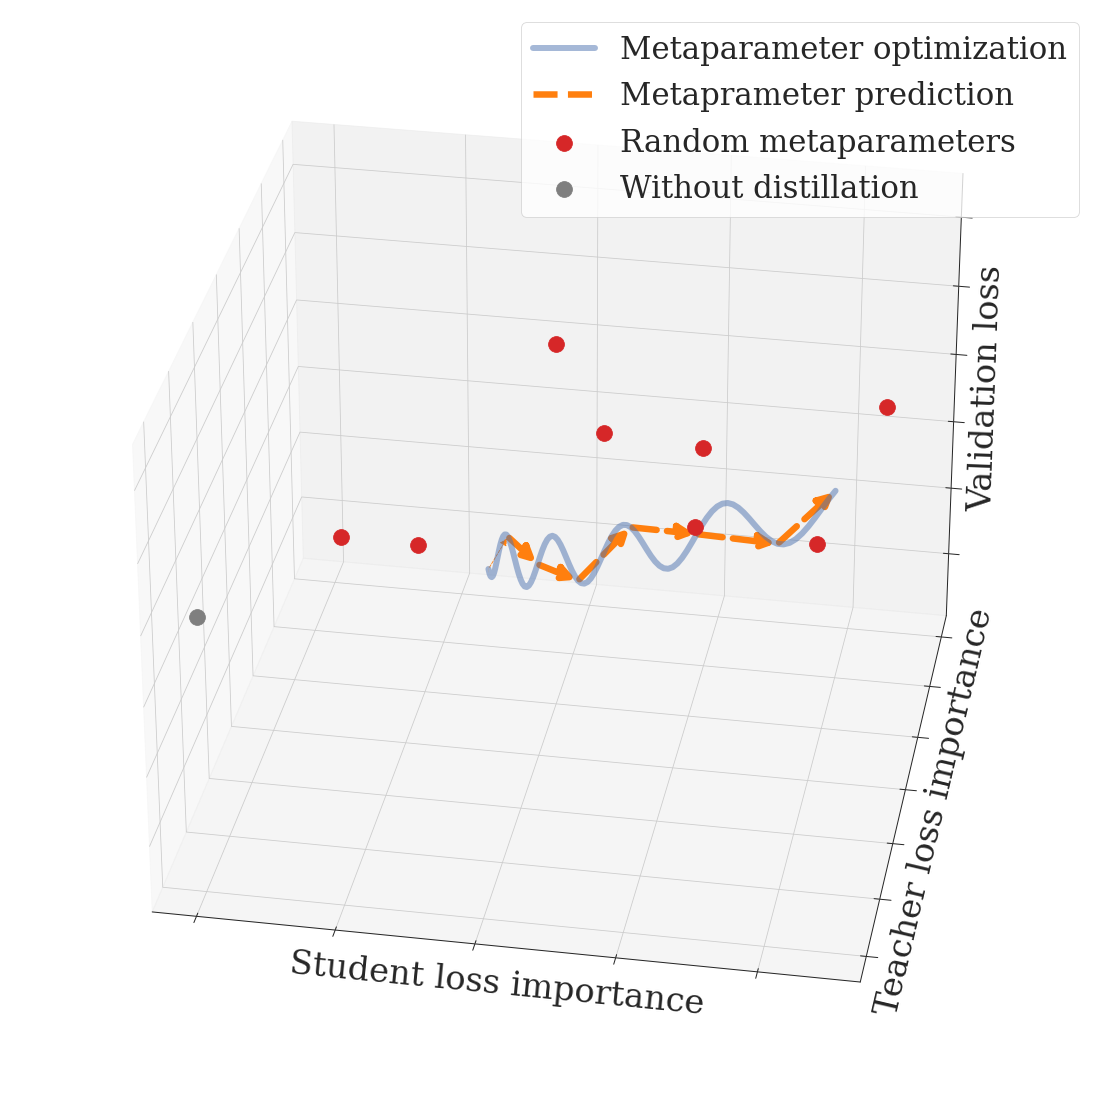

In [8]:
# %matplotlib notebook
# plt.rcParams['figure.figsize']=(8,8)
# plt.rcParams['lines.linewidth'] = 2

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(par1[0], par2[0], val[0], color='black', marker='o')
ax.plot3D(par1, par2, np.array(val) * 1.5, linewidth=6, label='Metaparameter optimization', alpha=0.5)
ax.plot3D([par1_[0], par1_[0]+0.0001], [par2_[0], par2_[0]+0.0001], 
          [val_[0], val_[0]+0.0001], linewidth=6.5, 
          label='Metaprameter prediction', color='tab:orange', ls='--')

ax.scatter3D(2*0.3, 1.5*(0.7-0.3), 1.07, color='tab:red', s=250)
ax.scatter3D(2*0.2, 1.5*(0.65-0.3), 0.7, color='tab:red', s=250)
ax.scatter3D(2*0.1, 1.5*(0.75-0.3), 0.67, color='tab:red', s=250)
ax.scatter3D(2*0.18, 1.5*(0.8-0.3), 0.8, color='tab:red', s=250)
ax.scatter3D(2*0.37, 1.5*(0.85-0.3), 0.79, color='tab:red', s=250)
ax.scatter3D(2*0.42, 1.5*(0.87-0.3), 0.84, color='tab:red', s=250)
ax.scatter3D(2*0.25, 1.5*(0.78-0.3), 1.0, color='tab:red', s=250)
ax.scatter3D(2*0.06, 1.5*(0.69-0.3), 0.95, color='tab:red', s=250, label='Random metaparameters')

ax.scatter3D(1, 1, .8, color='tab:grey', s=250, label='Without distillation')
#ax.scatter3D(1, 0, 1.25, color='tab:green', s=150, label='full distillation')

for i in range(len(par2_)-1):
    if i == 0:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=15, arrowstyle="-|>",
                   linestyle='dashed', 
                   ec='tab:orange', fc='tab:orange')
    else:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5, 
                   ec='tab:orange', fc='tab:orange')

ax.set_xlabel('Student loss importance')
ax.set_ylabel('Teacher loss importance')
ax.set_zlabel('Validation loss')
ax.legend(loc='best')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.view_init(30, 100)
# plt.savefig('../figs/trajectory.pdf')
plt.show()

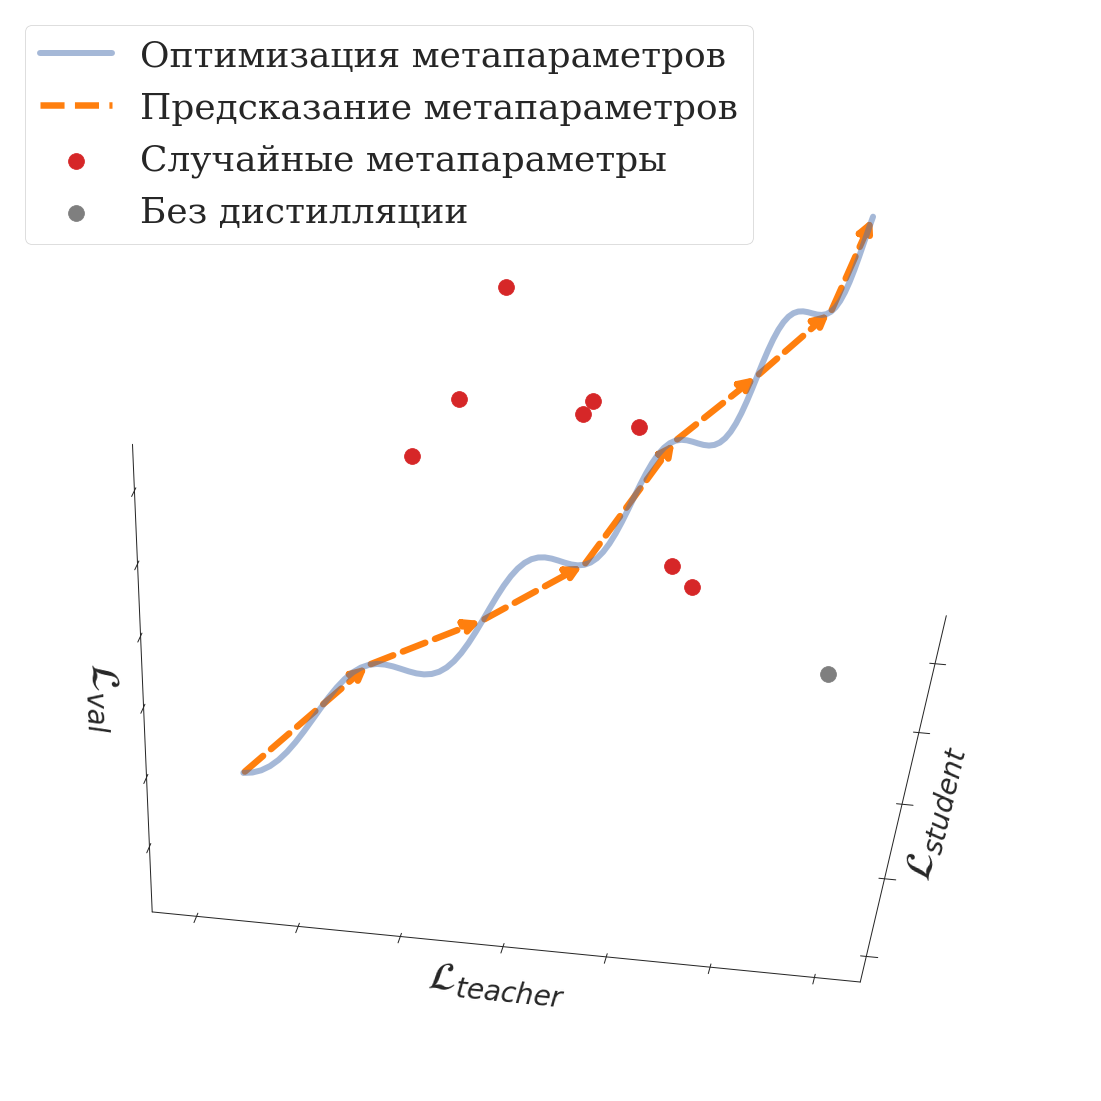

In [20]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40#22

# %matplotlib notebook
# plt.rcParams['figure.figsize']=(8,8)
# plt.rcParams['lines.linewidth'] = 2

fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(par1[0], par2[0], val[0], color='black', marker='o')
ax.plot3D(par1, par2, np.array(val) * 1.5, linewidth=6, label='Оптимизация метапараметров', alpha=0.5)
ax.plot3D([par1_[0], par1_[0]+0.0001], [par2_[0], par2_[0]+0.0001], 
          [val_[0], val_[0]+0.0001], linewidth=6.5, 
          label='Предсказание метапараметров', color='tab:orange', ls='--')

ax.scatter3D(2*0.3, 1.5*(0.7-0.3), 1.07, color='tab:red', s=250)
ax.scatter3D(2*0.2, 1.5*(0.65-0.3), 0.7, color='tab:red', s=250)
ax.scatter3D(2*0.1, 1.5*(0.75-0.3), 0.67, color='tab:red', s=250)
ax.scatter3D(2*0.18, 1.5*(0.8-0.3), 0.8, color='tab:red', s=250)
ax.scatter3D(2*0.37, 1.5*(0.85-0.3), 0.79, color='tab:red', s=250)
ax.scatter3D(2*0.42, 1.5*(0.87-0.3), 0.84, color='tab:red', s=250)
ax.scatter3D(2*0.25, 1.5*(0.78-0.3), 1.0, color='tab:red', s=250)
ax.scatter3D(2*0.06, 1.5*(0.69-0.3), 0.95, color='tab:red', s=250, label='Случайные метапараметры')

ax.scatter3D(1, 1, .8, color='tab:grey', s=250, label='Без дистилляции')
#ax.scatter3D(1, 0, 1.25, color='tab:green', s=150, label='full distillation')

for i in range(len(par2_)-1):
    if i == 0:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5,
                   ec='tab:orange', fc='tab:orange')
    else:
        ax.arrow3D(par1_[i], par2_[i], val_[i],
                   par1_[i+1]-par1_[i], par2_[i+1]-par2_[i], val_[i+1]-val_[i],
                   mutation_scale=30, arrowstyle="-|>",
                   linestyle='dashed', linewidth=6.5, 
                   ec='tab:orange', fc='tab:orange')

ax.set_xlabel('$\mathcal{L}_{student}$')
ax.set_ylabel('$\mathcal{L}_{teacher}$')
ax.set_zlabel('$\mathcal{L}_{val}$')
ax.legend(loc='best')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.view_init(30, 10)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
plt.savefig('../figs/trajectory_rus.pdf')
plt.show()

In [42]:
val

[0.06215987523460359,
 0.06161326735460486,
 0.06467870912631377,
 0.07167445906183736,
 0.08260647325759735,
 0.09716793212271294,
 0.11476362027376165,
 0.13455722236868065,
 0.15553777675129363,
 0.1766000064976898,
 0.1966321447568718,
 0.2146042757812224,
 0.22965017206561175,
 0.24113612481338312,
 0.24871129845813322,
 0.2523356080693326,
 0.2522829045022208,
 0.24911921419986194,
 0.2436577627134022,
 0.23689435577308654,
 0.22992825253225208,
 0.22387481839892756,
 0.21977689806390605,
 0.21852195102738953,
 0.22077153403797733,
 0.2269087337717109,
 0.23700772675222295,
 0.2508278852817349,
 0.2678328977258204,
 0.28723338385347696,
 0.3080496190161889,
 0.3291893831006516,
 0.3495347483748197,
 0.36803091006218625,
 0.3837700011639394,
 0.39606323160048496,
 0.40449561949377577,
 0.4089589656409601,
 0.40966045102659215,
 0.40710617421479917,
 0.4020609367407666,
 0.3954874719556523,
 0.3884699462029075,
 0.3821278109250447,
 0.37752685101527705,
 0.375594497514925,
 0.37704